# Example of SPHERE I/O

This is an example of I/O the SPHERE file using sphere.

## Requirements
* matplotlib
* numpy
* IPython

In [1]:
%matplotlib inline

In [2]:
import io
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from IPython import display

import sphere

file = './example_data/speech.sph'

plt.style.use({
    # FIGURE
    'figure.figsize': (8.2, 3.6),
    'figure.constrained_layout.use': True,
    # AXES
    'axes.grid': True,
    # LINES
    'lines.linewidth': 0.5,
    # TICKS
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # GRIDS
    'grid.linewidth': 0.3,
    'grid.alpha': 0.4,
})

## Read the SPHERE file

### Read header information

The `getparams` function returns header information in a specific data type (NamedTuple `_sph_params`).

In [3]:
with sphere.open(file, 'r') as fp:
    sph_params = fp.getparams()

print('* Raw value fom getparams()')
print(sph_params)
print()
print('* converte to python dict for readability.')
pprint(sph_params._asdict())

* Raw value fom getparams()
_sph_params(database_id='RM1', database_version='1.0', utterance_id='aks0_st0783', channel_count=1, sample_count=48743, sample_rate=16000, sample_min=-4326, sample_max=5772, sample_n_bytes=2, sample_byte_format='01', sample_sig_bits=16)

* converte to python dict for readability.
{'channel_count': 1,
 'database_id': 'RM1',
 'database_version': '1.0',
 'sample_byte_format': '01',
 'sample_count': 48743,
 'sample_max': 5772,
 'sample_min': -4326,
 'sample_n_bytes': 2,
 'sample_rate': 16000,
 'sample_sig_bits': 16,
 'utterance_id': 'aks0_st0783'}


Since the SPHERE file header can handle a variety of information, it is not unique what key `_sph_params` has. (Typically, it contins 'channe_count', 'sample_count' and 'samle_n_bytes'.)

In case you want to always use the same parameters, the same interface as the `wave` module is provided, which can be used with the `is_wavelike=True` option.

In [4]:
with sphere.open(file, 'r', is_wavelike=True) as fp:
    wave_params = fp.getparams()
    
    # And you can use the get* functions
    nchannels = fp.getnchannels()
    sampwidth = fp.getsampwidth()
    framerate = fp.getframerate()
    nframes = fp.getnframes()

print(wave_params)
print(f'    nchannels = {nchannels}')
print(f'    sampwidth = {sampwidth}')
print(f'    framerate = {framerate}')
print(f'      nframes = {nframes}')

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=48743, comptype='NONE', compname='not compressed')
    nchannels = 1
    sampwidth = 2
    framerate = 16000
      nframes = 48743


Note that 'comptype' and 'compname' are retained for compatibility, but will always return 'NONE' and 'not compress' even if compression parameters such as 'sample_coding' are set.

### Read data

In [5]:
with sphere.open(file, 'r') as fp:
    # This method is the same when the is_wavelike=True option.
    raw = fp.readframes(sph_params.sample_count)

dtype = np.dtype(f'i{sph_params.sample_n_bytes}')
dat = np.frombuffer(raw, dtype=dtype)

print(dat.shape, dat.dtype, dat.max(), dat.min(), sep=', ')

(48743,), int16, 5772, -4326


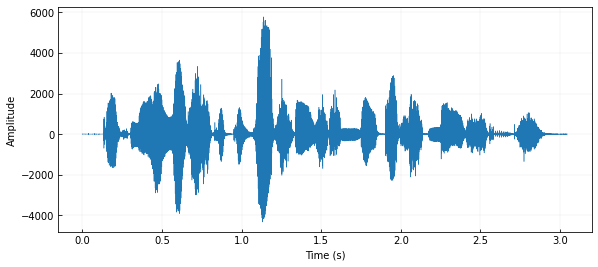

In [6]:
dur = sph_params.sample_count / sph_params.sample_rate
time = np.linspace(0, dur, sph_params.sample_count)

fig_r, ax_r = plt.subplots(figsize=(8.2, 3.6))
ax_r.plot(time, dat)
ax_r.set_xlabel('Time (s)')
ax_r.set_ylabel('Amplitude')

display.Audio(dat, rate=sph_params.sample_rate)

## Write the SPHERE file

We make the original audio to write SPHERE file, before demonstrate the writing file.

In [7]:
# Make dummy data
dur = 1.0   # (s)
fs = 16000  # (Hz)
fo = 400   # (Hz)
dtype = np.int16
sig_amp = 0.6
noise_scale = 0.16
seed = 417

rng = np.random.default_rng(seed)
taxis = np.linspace(0, dur, int(dur * fs), endpoint=True)
dummy_fdat = (np.sin(2 * np.pi * fo * taxis) * sig_amp 
              + rng.normal(0, noise_scale, len(taxis)))

dinfo = np.iinfo(dtype)
dummy_dat = np.clip(dummy_fdat * dinfo.max, dinfo.min, dinfo.max).astype(dtype)

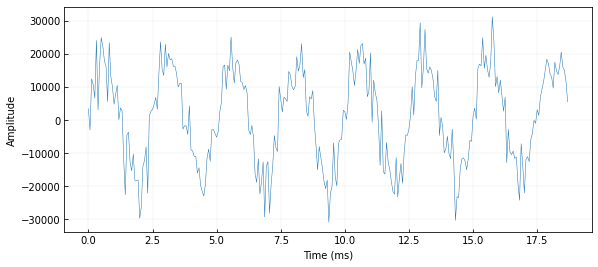

In [8]:
fig_o, ax_o = plt.subplots()
ax_o.plot(taxis[:300] * 1e3, dummy_dat[:300])
ax_o.set_xlabel('Time (ms)')
ax_o.set_ylabel('Amplitude')

display.Audio(dummy_dat, rate=fs)

You can use the `setparams` only to set the any parameters. 
And `setparams` takes only dict of header information.

`sample_n_bytes` and `channel_count` are required as params.
Also, `sample_rate` is required if `sample_coding` is `'pcm'`, `'ulaw'` or not given.
If these are not set, it will send an error when trying to write data.
`sample_count` is calculated internally and set automatically.

*NOTE: In this example, a `io.BytesIO` object is given for demonstration, but the path of the file to be written can also be given.*

In [9]:
iofp = io.BytesIO()
iofp.read = iofp.read1

with sphere.open(iofp, 'w') as fp:
    fp.setparams({
        'channel_count': 1,
        'sample_n_bytes': dinfo.bits // 8,
        'sample_count': len(dummy_dat),
        'sample_rate': fs,
    })
    fp.writeframes(dummy_dat.tobytes())

In [10]:
iofp.seek(0)
with sphere.open(iofp) as fp:
    org_sphp = fp.getparams()
    org_raw = fp.readframes(org_sphp.sample_count)
iofp.close()

org_dat = np.frombuffer(org_raw, dtype=np.dtype(f'i{org_sphp.sample_n_bytes}'))

pprint(org_sphp._asdict())

{'channel_count': 1,
 'sample_count': 16000,
 'sample_n_bytes': 2,
 'sample_rate': 16000}


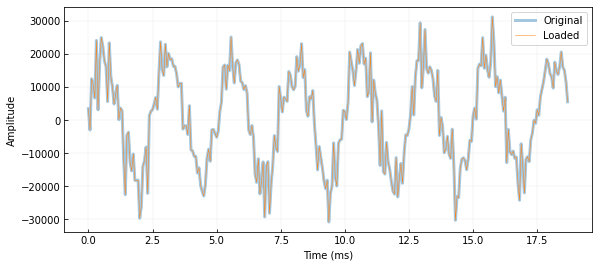

In [11]:
fig_w, ax_w = plt.subplots()
ax_w.plot(taxis[:300] * 1e3, dummy_dat[:300], lw=3.0, alpha=0.4, 
          label='Original')
ax_w.plot(taxis[:300] * 1e3, org_dat[:300], label='Loaded')
ax_w.set_xlabel('Time (ms)')
ax_w.set_ylabel('Amplitude')
ax_w.legend()

display.Audio(org_dat, rate=fs)

In [12]:
if np.allclose(org_dat, dummy_dat):
    print('Missing data is nothing.')
else:
    error = np.mean(np.power(org_dat - dummy_dat, 2))
    print(f'MSE: {error:.6f}')

Missing data is nothing.
